In [1]:
# upload json file with username and api

from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vedantsonani","key":"436d72c86ab0fd5d8542f7b606aed78f"}'}

In [2]:
# store the json file in /.kaggle/kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download the zip file

!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 97% 1.41G/1.45G [00:06<00:00, 136MB/s] 
100% 1.45G/1.45G [00:06<00:00, 229MB/s]


In [4]:
# unzip the data

!unzip -q /content/wildfire-prediction-dataset.zip -d /content/wildfire_dataset

In [5]:
# import all the necessary library

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import matplotlib.pyplot as plt

In [6]:
# image data generation for training

image_size = (224, 224)
batch_size = 32

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data generator for training (with augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    '/content/wildfire_dataset/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/wildfire_dataset/valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # keep it off for evaluation
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [47]:
# setting up ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

In [48]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
# training the model

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 465s 437ms/step - accuracy: 0.9296 - loss: 0.1869 - val_accuracy: 0.9506 - val_loss: 0.1221 - learning_rate: 0.0010
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 436s 435ms/step - accuracy: 0.9545 - loss: 0.1233 - val_accuracy: 0.9676 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 411s 435ms/step - accuracy: 0.9585 - loss: 0.1158 - val_accuracy: 0.9729 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 418s 442ms/step - accuracy: 0.9609 - loss: 0.1051 - val_accuracy: 0.9705 - val_loss: 0.0918 - learning_rate: 0.0010
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 413s 437ms/step - accuracy: 0.9642 - loss: 0.1003 - val_accuracy: 0.9730 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 408s 432ms/step - accuracy: 0.9616 - loss: 0.1022 - val_accuracy: 0.9756 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 410s 433ms/step - accura

In [51]:
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])

print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


Final Training Accuracy: 0.967206597328186
Final Validation Accuracy: 0.9796825647354126
Final Training Loss: 0.08992009609937668
Final Validation Loss: 0.06019444391131401


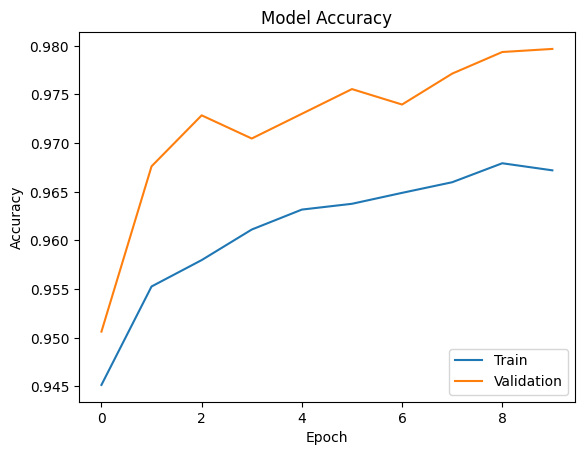

In [52]:
# ploting accuracy during train and validation

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

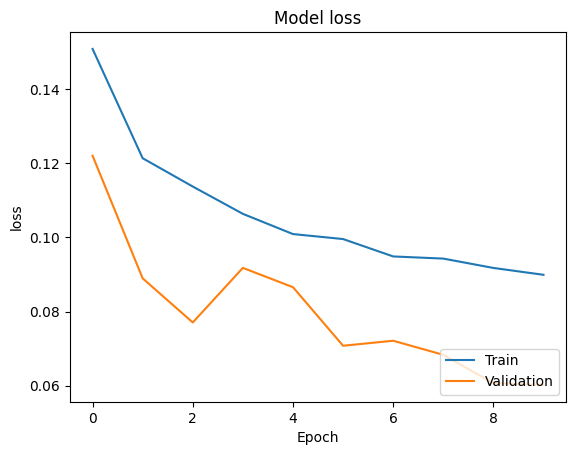

In [53]:
# ploting loss during train and validation


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

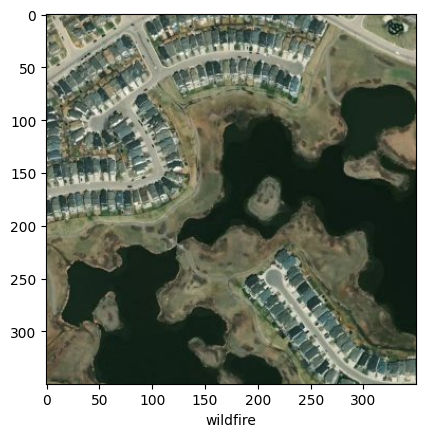

In [61]:
import matplotlib.image as mping
test_img_path = "/content/wildfire_dataset/test/nowildfire/-113.91777,50.901087.jpg"
img = mping.imread(test_img_path)
imgplot = plt.imshow(img)
plt.xlabel("wildfire")
plt.show()

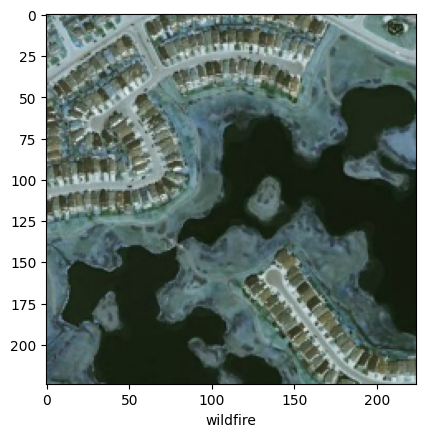

In [62]:
import cv2
import numpy as np

test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(224,224))
test_image = np.array(test_image)
test_image = test_image.reshape(1,224,224,3)
test_arr.append(test_image)

In [63]:
model.predict(test_image)

# 0 --> nowildfire
# 1 --> wildfire

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[5.6400523e-07]], dtype=float32)